In [124]:
%pip install pymorphy2
%pip install python-Levenshtein

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [133]:
import pandas as pd
import numpy as np

import pymorphy2
import Levenshtein
import gensim.downloader

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [116]:
# installing model
word2vec_rus = gensim.downloader.load('word2vec-ruscorpora-300')

In [141]:
data = pd.read_csv("Data\paronym.csv", index_col=0)

In [142]:
morph = pymorphy2.MorphAnalyzer()

# get a part of speech needed to make an embedding of word
def get_part_of_speech(word):
    
    parsed_word = morph.parse(word)[0]
    pos = parsed_word.tag.POS

    if pos == "ADJF":
        return "ADJ"
    
    return pos 

In [143]:
# making embedding by pretrained word2vec model 
def get_embedding(word):

    w2v_word = f"{word}_{get_part_of_speech(word)}"

    try:
        emb = word2vec_rus[w2v_word]

    except KeyError:
        return None
    
    return emb

In [144]:
# add extra columns for embeddings 
for i in range(600):
    data[f"emb_{int(i > 299) + 1}_{i % 300}"] = 0
# add extra columns for Levenshtein distance
data["lev_dist"] = 0

rows_to_drop = []

# add embeddings to dataframe 
for i in range(len(data)):

    # get embs for two words
    word1 = data.word1[i]
    word2 = data.word2[i]
    emb1 = get_embedding(word1)
    emb2 = get_embedding(word2)

    if emb1 is not None and emb2 is not None:
        # add embeddings
        data.loc[i, "emb_1_0":"emb_1_299"] = emb1
        data.loc[i, "emb_2_0":"emb_2_299"] = emb2
        data.loc[i, "lev_dist"] = Levenshtein.distance(word1, word2)
        # print("YES", data.word1[i], data.word2[i])

    else: 
        # delete words that are not in word2vec vocabulary
        rows_to_drop.append(i)
        # print("NO", data.word1[i], data.word2[i])

data = data.drop(rows_to_drop, axis=0).reset_index(drop=True)
data.head()

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,аккордовый,квадрат,0,-0.012578,0.071381,-0.066920,0.132629,0.039623,0.068954,-0.102715,...,0.012084,0.054774,0.012667,-0.049291,0.144537,-0.074161,-0.035057,0.081322,0.129544,8
1,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,2
2,женский,господний,0,0.044881,-0.092671,0.050879,-0.044229,0.011045,0.028815,-0.058337,...,0.073815,0.014237,0.103689,0.109344,0.009336,0.047421,0.005184,0.071654,-0.028561,7
3,обличительный,динамизм,0,0.066741,0.038244,0.027620,0.058278,0.048305,0.110592,-0.115581,...,-0.102109,0.129003,-0.052745,-0.043174,-0.039006,0.050456,-0.007910,-0.029959,0.016620,12
4,фактичный,ординарный,0,0.032032,-0.006285,-0.047780,0.033934,-0.016947,0.057922,-0.048563,...,-0.053290,-0.077826,-0.116725,-0.032819,-0.008684,-0.138111,0.051320,-0.003383,-0.044410,7


In [145]:
# fitting PCA
def fit_pca(X):
    pca = PCA(n_components=150)
    pca.fit(X)
    return pca

# transform dataset to n_componets dimansion
def reduce_dimension(pca, X):
    X_transformed = pca.transform(X)
    return X_transformed

In [154]:
X = data.drop(["word1", "word2", "label"], axis=1)
y = data["label"]

pca_n_components = 150

# fit PCA
pca_word1 = fit_pca(X.loc[:, "emb_1_0":"emb_1_299"])
pca_word2 = fit_pca(X.loc[:, "emb_2_0":"emb_2_299"])

# reduce dimensuon with PCA
X.loc[:, "emb_1_0":f"emb_1_{299-pca_n_components}"] = reduce_dimension(pca_word1, X.loc[:, "emb_1_0":"emb_1_299"])
X.loc[:, f"emb_2_0":f"emb_2_{299-pca_n_components}"] = reduce_dimension(pca_word2, X.loc[:, "emb_2_0":"emb_2_299"])

# drop extra columns of embedding
X = X.drop(list(X.columns[pca_n_components:300]) + list(X.columns[300+pca_n_components:-1]), axis=1)
X

,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,emb_1_7,emb_1_8,emb_1_9,...,emb_2_141,emb_2_142,emb_2_143,emb_2_144,emb_2_145,emb_2_146,emb_2_147,emb_2_148,emb_2_149,lev_dist
0,-0.275446,0.044741,-0.241886,0.003605,0.105008,-0.091422,-0.197058,0.008812,0.076936,0.068273,...,-0.013632,0.050526,-0.015290,0.010189,0.004437,0.006554,0.026939,-0.030555,0.015299,8
1,0.098267,0.063110,0.019686,-0.087348,0.098161,-0.038633,-0.053926,0.079069,0.026610,0.060413,...,0.024749,-0.001563,0.039808,-0.012893,0.015999,-0.037705,0.060936,0.017698,-0.003606,2
2,0.101184,-0.064612,-0.031630,0.041136,0.117799,-0.064814,0.048414,0.013331,0.186842,-0.080586,...,0.038615,-0.036835,-0.023649,0.063649,-0.007232,-0.011265,-0.020813,-0.013832,-0.037673,7
3,-0.127065,-0.331509,0.041632,0.036336,0.127611,-0.019456,-0.234091,0.163452,0.023490,-0.055083,...,0.020287,0.027448,0.013132,0.046634,-0.009076,-0.033589,0.031341,-0.059938,0.033282,12
4,-0.333439,-0.220895,-0.070374,-0.114968,0.026101,-0.206609,0.050687,0.016106,-0.021288,0.047321,...,-0.032910,-0.033604,0.136783,0.015537,-0.021456,-0.051895,-0.026541,-0.003640,0.073687,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,-0.033532,0.025578,0.022510,0.033889,-0.093528,-0.178120,0.075203,0.011541,0.002020,0.050408,...,0.015635,-0.050219,-0.005004,0.003020,-0.049299,-0.000238,-0.028912,0.004671,-0.003470,10
1902,0.036644,0.127105,-0.309829,0.019796,-0.036374,0.045638,-0.113020,-0.096569,0.183820,0.147861,...,0.023386,0.066165,0.003633,-0.048862,0.046246,0.069684,0.054143,-0.037978,0.012753,6
1903,0.261491,0.014881,-0.004136,-0.150730,-0.037913,0.066045,0.098547,0.321893,-0.042387,-0.113172,...,0.002439,0.068836,0.022897,-0.022589,0.003929,-0.023483,-0.013905,-0.005591,0.010010,4
1904,0.004660,0.136387,0.061175,0.180032,0.110221,-0.087452,-0.075509,-0.022882,0.139744,0.042896,...,-0.016136,-0.037090,0.038002,0.019665,0.005240,-0.049940,0.053549,0.006028,0.113553,2


In [155]:
print(f"Explained for variance for word1 - np.sum(pca_word1.explained_variance_ratio_), np.sum(pca_word2.explained_variance_ratio_)

(0.8217606373629005, 0.8217768613526459)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(verbose=0)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print('MAE:', mae)

MAE: 0.06544502617801047


In [109]:
# get feature importance
feature_importances = model.feature_importances_

for i, importance in enumerate(feature_importances):
    print(f"{X.columns[i]}: {importance}")

emb_1_0: 0.06269104619933379
emb_1_1: 0.10750292079823455
emb_1_2: 0.08707085700270036
emb_1_3: 0.09346729478491465
emb_1_4: 0.01223692312684047
emb_1_5: 0.08751018484507392
emb_1_6: 0.11138941738043927
emb_1_7: 0.0696686482479348
emb_1_8: 0.09151310800680121
emb_1_9: 0.10118704188061894
emb_1_10: 0.07678324008628105
emb_1_11: 0.11109518379234558
emb_1_12: 0.046767474126262316
emb_1_13: 0.04660918696747877
emb_1_14: 0.02288724709770713
emb_1_15: 0.056104311716642166
emb_1_16: 0.041627322054464434
emb_1_17: 0.06265128925167707
emb_1_18: 0.05751129268070252
emb_1_19: 0.02328237728093887
emb_1_20: 0.08959113781553688
emb_1_21: 0.0372291070348028
emb_1_22: 0.029376461382503313
emb_1_23: 0.19914575089412942
emb_1_24: 0.025205275169832255
emb_1_25: 0.03175215810969865
emb_1_26: 0.10763354872939311
emb_1_27: 0.0371184352173716
emb_1_28: 0.07967831267812138
emb_1_29: 0.06660832994181781
emb_1_30: 0.42211714015073737
emb_1_31: 0.0304298030820966
emb_1_32: 0.15280997263031942
emb_1_33: 0.1457579

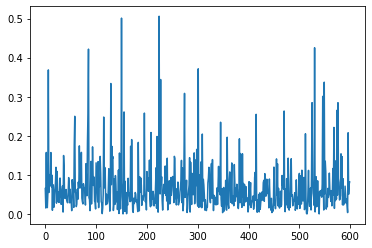

In [123]:
# plotting feature importance of embeddings
plt.plot(model.feature_importances_[:-1])

In [97]:
data

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,аккордовый,квадрат,0,-0.012578,0.071381,-0.066920,0.132629,0.039623,0.068954,-0.102715,...,0.012084,0.054774,0.012667,-0.049291,0.144537,-0.074161,-0.035057,0.081322,0.129544,0
1,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,0
2,женский,господний,0,0.044881,-0.092671,0.050879,-0.044229,0.011045,0.028815,-0.058337,...,0.073815,0.014237,0.103689,0.109344,0.009336,0.047421,0.005184,0.071654,-0.028561,0
3,обличительный,динамизм,0,0.066741,0.038244,0.027620,0.058278,0.048305,0.110592,-0.115581,...,-0.102109,0.129003,-0.052745,-0.043174,-0.039006,0.050456,-0.007910,-0.029959,0.016620,0
4,сыскать,снискать,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,гнилой,гнилостный,1,0.022569,-0.047862,0.049707,0.058395,0.006504,0.046971,0.035626,...,-0.091607,0.088824,0.001456,-0.006952,0.041889,0.050071,0.102235,-0.003491,-0.002087,0
3512,кормильщица,притягательный,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3513,абонемент,абонент,1,0.068919,0.042074,-0.030451,-0.087799,0.016597,-0.016370,0.019723,...,0.067424,0.100960,0.029388,-0.060928,0.016881,-0.025644,-0.061658,-0.017059,-0.043113,0
3514,беженец,выучить,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [96]:
get_embedding(data['word1'][0])

array([-1.25777004e-02,  7.13808015e-02, -6.69195578e-02,  1.32629201e-01,
        3.96230109e-02,  6.89538270e-02, -1.02715276e-01, -2.07985435e-02,
       -4.17454605e-04, -6.66920096e-02,  1.85652584e-01, -1.44832075e-01,
        2.83512380e-02, -1.11901104e-01,  4.56056818e-02, -4.81510274e-02,
        8.36276039e-02, -9.19803232e-03,  9.81500838e-04,  5.74996658e-02,
       -2.92572589e-03,  6.52177706e-02, -4.75657806e-02,  4.61040102e-02,
       -3.82861830e-02,  5.70593216e-02, -3.37926932e-02,  1.21076353e-01,
       -1.81092322e-02,  9.62400343e-03, -1.48299234e-02,  1.01952113e-01,
        1.60059571e-01, -5.47798118e-03,  3.87733914e-02,  3.83970179e-02,
        1.25514701e-01, -8.64881873e-02,  2.29348727e-02, -2.13215649e-02,
       -1.91617105e-02, -1.42319629e-03, -1.11882702e-01, -8.07544217e-02,
       -5.52563854e-02,  1.29661132e-02, -3.10040861e-02, -4.55451086e-02,
        4.72736470e-02, -7.49781057e-02, -9.20100696e-03,  5.29071130e-02,
        6.45692181e-03,  

In [85]:
morph = pymorphy2.MorphAnalyzer()

word = 'знамя_NOUN'
parsed_word = morph.parse(word)[0]
pos = parsed_word.tag.POS

print(pos)

None


In [ ]:


# Создаем набор данных
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])

# Создаем объект PCA и указываем, что хотим снизить размерность до 2
pca = PCA(n_components=2)

# Обучаем PCA на наборе данных
pca.fit(X)

# Применяем PCA для снижения размерности
X_transformed = pca.transform(X)

# Выводим преобразованный набор данных
print(X_transformed)